### (PSL) Coding Assignment 1

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |

#### Background

This assignment is related to the simulation study described in Section 2.3.1 (the so-called Scenario 2 or Example 2) of "Elements of Statistical Learning" (ESL).

#### The Scenario 2

The two-dimensional data $X \in R^2$ in each class are generated from a mixture of 10 different bivariate Gaussian distributions with uncorrelated components and different means, i.e.,

$$X | Y = k, Z = j \sim \mathcal{N}(\mathbf{m}_{kj}, s^2 I_2)$$

where $k = 0, 1,$ and $j = 1, 2, \ldots, 10$. Set

$$P(Y = k) = 1/2, \quad P(Z = j) = 1/10, \quad s^2 = 1/5.$$

In other words, given $Y = k$, $X$ follows a mixture distribution with probability density function (PDF)

$$\frac{1}{10} \sum_{j=1}^{10} \left(\frac{1}{\sqrt{2\pi s^2}}\right)^2 e^{-\|\mathbf{x}-\mathbf{m}_{kj}\|^2/(2s^2)}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# set random seed
np.random.seed(1160)

#### Part 1: Generate Data
Generate the 20 centers, 10 for each class (2 classes/binary classification).

In [2]:
N_CENTER = 10
N_CLASS = 2

# standard deviation for generating the centers within each class
SIGMA_CENTER = 1

# standard deviation for generating both training and test data
SIGMA_DATA = 1/np.sqrt(5)

# 20 centers from two-dimensional normal distribution
# 10 for each group (2 classes)
M1 = np.random.normal(size=(N_CENTER, N_CLASS)) * SIGMA_CENTER \
    + np.concatenate([np.array([[1, 0]] * N_CENTER)])
M0 = np.random.normal(size=(N_CENTER, N_CLASS)) * SIGMA_CENTER \
    + np.concatenate([np.array([[0, 1]] * N_CENTER)])

print(f"class 1 centers: \n{M1}\n")
print(f"class 0 centers: \n{M0}")

class 1 centers: 
[[ 0.96828955 -0.26711392]
 [ 1.42101135 -1.49540693]
 [ 3.36460335  0.30660688]
 [ 0.40296675 -0.63819358]
 [ 1.41438871 -0.1197446 ]
 [ 1.5077573  -0.62955769]
 [ 0.8932898  -1.01733212]
 [ 0.30762696  1.83557616]
 [ 0.34259866 -0.37390503]
 [ 1.31051656 -1.60042664]]

class 0 centers: 
[[-0.47189236  2.90149477]
 [-0.75538773 -0.17483476]
 [-0.71403438  1.83975604]
 [ 0.76259369  1.54529581]
 [-1.38972277  1.0660958 ]
 [ 1.12740047  1.10797023]
 [ 0.56169959 -0.14154544]
 [-0.68087695  0.48303666]
 [ 0.44702504 -0.24622898]
 [ 0.53384967  0.88635114]]


In [3]:

def generate_data(n_size: int, sigma: float) -> tuple[np.ndarray, np.ndarray]:
    """Helper function to generate data using normal distribution with the given sigma

    Args:
        n_size (int): number of samples for each class
        sigma (float): standard deviation

    Returns:
        X (np.ndarray): generated data
        y (np.ndarray): generated labels
    """
    
    # Randomly allocate the n samples for class 1 to the 10 clusters
    id1 = np.random.randint(N_CENTER, size=n_size)
    id0 = np.random.randint(N_CENTER, size=n_size)

    # Generate the training data
    X = np.random.normal(size=(2 * n_size, N_CLASS)) * sigma \
        + np.concatenate([M1[id1, :], M0[id0, :]])
    y = np.concatenate(([1]*n_size, [0]*n_size))
    return X, y

In [4]:
# Gerernating training data
# Randomly allocate the n samples for class 1 to the 10 clusters
N_TRAIN = 100
X_train, y_train = generate_data(N_TRAIN, SIGMA_DATA)

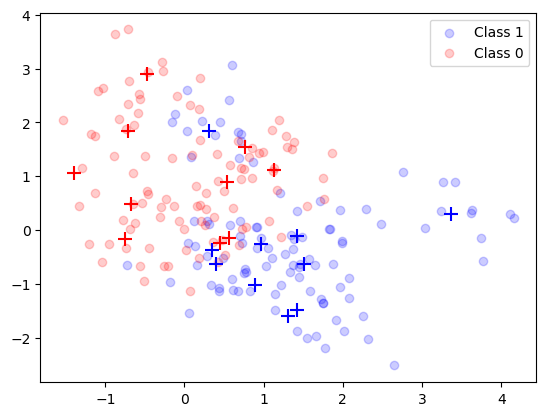

In [5]:
# Visualize the training data
plt.scatter(X_train[:N_TRAIN, 0], X_train[:N_TRAIN, 1],
            c="blue", alpha=0.2, label='Class 1')
plt.scatter(X_train[N_TRAIN:, 0], X_train[N_TRAIN:, 1],
            c="red", alpha=0.2, label='Class 0')

plt.scatter(M1[:, 0], M1[:, 1], marker='+', s=100, c="blue")
plt.scatter(M0[:, 0], M0[:, 1], marker='+', s=100, c="red")

plt.legend()
plt.show()

In [6]:
# Generate the test data
N_TEST = 5000
X_test, y_test = generate_data(N_TEST, SIGMA_DATA)

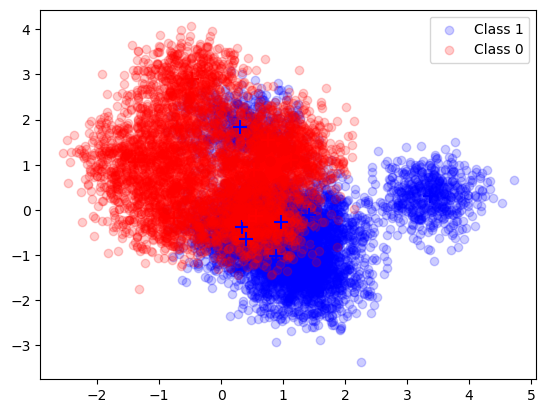

In [7]:
# Visualize the test data (optional)
plt.scatter(X_test[:N_TEST, 0], X_test[:N_TEST, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(X_test[N_TEST:, 0], X_test[N_TEST:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(M1[:,0], M1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(M0[:,0], M0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

#### Part 2: kNN

Handling ties
- Distance ties: Ignored by sorting the distance and only take the first k results
- Voting ties: Using the majority votes to pick the class or use random choice when K is even.

In [8]:
from collections import Counter

class KNN:
    def __init__(self, n_neighbors: int = 3):
        """
        Args:
            n_neighbors (int): number of neighbors
        """
        self.K = n_neighbors

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X_train = X
        self.y_train = y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict the class labels using kNN

        Args:
            X (np.ndarray): test data

        Returns:
            np.ndarray: predicted labels
        """
        # Compute the Euclidean distance with vectorization
        # Reference: https://jaykmody.com/blog/distance-matrices-with-numpy/
        x2 = np.sum(X**2, axis=1, keepdims=True)
        y2 = np.sum(self.X_train**2, axis=1)
        xy = np.matmul(X, self.X_train.T)
        x2 = x2.reshape(-1, 1)
        dists = np.sqrt(x2 + y2 - 2 * xy)

        # Get the indices of the k nearest neighbors
        knn_indices = np.argsort(dists, axis=1)[:, :self.K]

        # Extract the labels of the k nearest neighbors
        knn_labels = self.y_train[knn_indices]

        # Determine the most common class label among the k neighbors
        return np.apply_along_axis(self._handle_ties, axis=1, arr=knn_labels)

    def _handle_ties(self, knn_labels: np.ndarray) -> int:
        """Helper function to handle voting ties

        Args:
            knn_labels (np.ndarray): labels of the k nearest neighbors

        Returns:
            int: predicted label
        """
        counts = Counter(knn_labels)
        most_common = counts.most_common()
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            return np.random.choice([label for label, count in most_common])
        return most_common[0][0]

In [9]:
# Test the kNN implementation
NUM_FOLDS = [1, 3, 5]
results = {}
for K in NUM_FOLDS:
    knn = KNN(K)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[K] = y_pred


### Confusion matrix

The confusion matrix is a 2x2 matrix for binary classification:

|                   | Predicted Negative | Predicted Positive |
|-------------------|---------------------|---------------------|
| Actual Negative   |         TN          |         FP          |
| Actual Positive   |         FN          |         TP          |

Where:
- TN (True Negative): Correctly predicted negative class
- FP (False Positive): Incorrectly predicted positive class
- FN (False Negative): Incorrectly predicted negative class
- TP (True Positive): Correctly predicted positive class

The matrix provides a comprehensive view of the model's performance, showing both correct and incorrect predictions for each class. The performance of the above self-implemented kNN is same as the one provided by sklearn.

In [10]:
def print_confusion_matrix(cm: np.ndarray):
    """Utility function to print confusion matrix

    Args:
        cm (np.ndarray): confusion matrix
    """
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix| Predicted Negative | Predicted Positive |")
    print("Actual Negative | {:>18} | {:>19}|".format(tn, fp))
    print("Actual Positive | {:>18} | {:>19}|\n".format(fn, tp))

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Compute and print confusion matrices for each k value
for K in NUM_FOLDS:
    y_pred = results[K]
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix of KNN with k={K} (custom kNN):")
    print_confusion_matrix(cm)


Confusion Matrix of KNN with k=1 (custom kNN):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4006 |                 994|
Actual Positive |               1076 |                3924|

Confusion Matrix of KNN with k=3 (custom kNN):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4091 |                 909|
Actual Positive |                933 |                4067|

Confusion Matrix of KNN with k=5 (custom kNN):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4166 |                 834|
Actual Positive |                888 |                4112|



In [12]:
# compare this with sklearn.neighbors.KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

for K in NUM_FOLDS:
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix of KNN with k={K} (sklearn):")
    print_confusion_matrix(cm)

Confusion Matrix of KNN with k=1 (sklearn):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4006 |                 994|
Actual Positive |               1076 |                3924|

Confusion Matrix of KNN with k=3 (sklearn):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4091 |                 909|
Actual Positive |                933 |                4067|

Confusion Matrix of KNN with k=5 (sklearn):
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4166 |                 834|
Actual Positive |                888 |                4112|



#### Park 3: cvKNN

In [13]:

from sklearn.model_selection import KFold


def cvknn_best_k(X_train: np.ndarray, y_train: np.ndarray, K_VALUES: list[int] = range(1, 180), CV_FOLDS: int = 10) -> int:
    """
    Provided the training data, uses cross-validation to find the best k value.
    Args:
        X_train (np.ndarray): training data
        y_train (np.ndarray): training labels
        K_VALUES (list[int]): list of k values to try, default is range(1, 180)
        CV_FOLDS (int): number of folds for cross-validation, default is 10 folds
    Returns:
        int: best k value
    """
    kf = KFold(n_splits=CV_FOLDS)
    cv_results = {k: [] for k in K_VALUES}

    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
        y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

        for K in K_VALUES:
            knn = KNeighborsClassifier(K)  # using sklearn
            knn.fit(X_train_cv, y_train_cv)
            y_pred_cvknn = knn.predict(X_val_cv)
            error = np.mean(y_pred_cvknn != y_val_cv)
            cv_results[K].append(error)

    # get the average cv error for each k and find the minimum
    avg_cv_error = {k: np.mean(v) for k, v in cv_results.items()}

    # find all k with the minimum value and pick the biggest k
    best_k = max([k for k, v in avg_cv_error.items()
                 if v == min(avg_cv_error.values())])

    return best_k

In [14]:
# Using cross-validation to find the best k
CV_FOLDS = 10
best_k = cvknn_best_k(X_train, y_train)
print(f"Best k: {best_k}")

# Retrain with the best k and evaluate on test data
cvknn = KNeighborsClassifier(best_k)  # using sklearn
cvknn.fit(X_train, y_train)
y_pred_cvknn = cvknn.predict(X_test)

# Generate confusion matrix
cm_cvknn = confusion_matrix(y_test, y_pred_cvknn)

print(f"Best k: {best_k}")
print("Confusion Matrix of cvKNN:")
print_confusion_matrix(cm_cvknn)

Best k: 31
Best k: 31
Confusion Matrix of cvKNN:
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4369 |                 631|
Actual Positive |                969 |                4031|



#### Part 4: Bayes rule

In [15]:
def bayes_predict(X: np.ndarray, m0: np.ndarray, m1: np.ndarray) -> np.ndarray:
    """Predict the class labels using Bayes rule

    Args:
        X (np.ndarray): test data
        m0 (np.ndarray): centers of class 0
        m1 (np.ndarray): centers of class 1
    Returns:
        np.ndarray: predicted labels
    """
    # Compute distances for all samples with vectorization
    dist_m1 = np.sum((X[:, np.newaxis, :] - m1[np.newaxis, :, :])**2, axis=2)
    dist_m0 = np.sum((X[:, np.newaxis, :] - m0[np.newaxis, :, :])**2, axis=2)

    # Compute the exponentials terms
    exp_m1 = np.sum(np.exp(-dist_m1 / (2 * SIGMA_DATA**2)), axis=1)
    exp_m0 = np.sum(np.exp(-dist_m0 / (2 * SIGMA_DATA**2)), axis=1)

    # Make predictions
    return (exp_m1 >= exp_m0).astype(int)

In [16]:
# Predict using Bayes rule
y_pred_bayes = bayes_predict(X_test, M0, M1)

# Generate confusion matrix
cm_bayes = confusion_matrix(y_test, y_pred_bayes)

print("Confusion Matrix of Bayes Rule:")
print_confusion_matrix(cm_bayes)

Confusion Matrix of Bayes Rule:
Confusion Matrix| Predicted Negative | Predicted Positive |
Actual Negative |               4159 |                 841|
Actual Positive |                724 |                4276|



#### Part 5: Simulation Study
Given the 20 centers generated in Part 1, repeatedly generate 50 training/test datasets (training size = 200
and test size = 10,000). For each pair of training/test datasets, calculate the test errors (the averaged 0/1
loss on the test data set) for each of the following three procedures:

1. kNN with K = 7
2. kNN with K chosen by 10-fold CV (using the implementation from Part 3)
3. the Bayes rule (using the implementation fomr Part 4)

In [17]:

# Generate 50 training/test datasets
N_DATASETS = 50
test_errors = {
    'kNN_7': [],
    'cvKNN': [],
    'Bayes': []
}
best_k = np.zeros(N_DATASETS, dtype=int)

for i in range(N_DATASETS):
    print(f"iteration {i+1} / {N_DATASETS}...", end="\r")
    # 0. Generate training and test data
    X_train, y_train = generate_data(n_size=100, sigma=SIGMA_DATA)
    X_test, y_test = generate_data(n_size=500, sigma=SIGMA_DATA)

    # 1. kNN with K = 7
    knn7 = KNeighborsClassifier(n_neighbors=7)
    knn7.fit(X_train, y_train)
    y_pred_knn7 = knn7.predict(X_test)
    test_errors['kNN_7'].append(
        np.mean(y_pred_knn7 != y_test))  # compute the test error

    # 2. 10-fold cvKNN
    best_k[i] = cvknn_best_k(X_train, y_train)
    
    # Retrain with the best k and evaluate on test data
    cvknn = KNeighborsClassifier(n_neighbors=best_k[i])
    cvknn.fit(X_train, y_train)
    y_pred_cvKNN = cvknn.predict(X_test)
    test_errors['cvKNN'].append(
        np.mean(y_pred_cvKNN != y_test))  # compute the test error

    # 3. Bayes rule
    y_pred_bayes = bayes_predict(X_test, M0, M1)
    test_errors['Bayes'].append(
        np.mean(y_pred_bayes != y_test))  # compute the test error

**Graph Report**

Plot the test errors for each procedure with strip chart

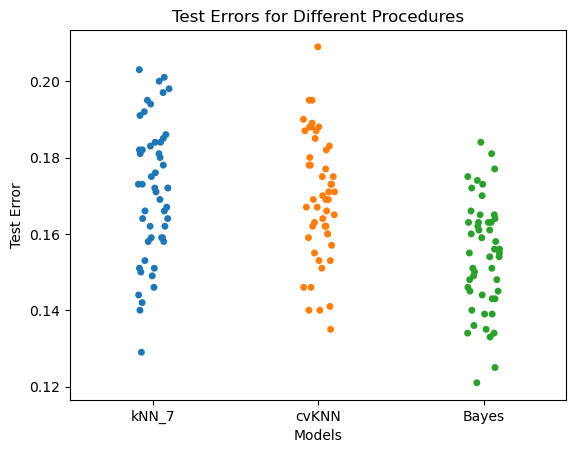

In [19]:
import seaborn as sns
sns.stripplot(data=test_errors)
plt.title("Test Errors for Different Procedures")
plt.xlabel("Models")
plt.ylabel("Test Error")
plt.show()

**Numerical Report**

Report the (min, max, median, 25% quantile, 75% quantile) for the 50 selected K values.

In [20]:
print(f"five-number summary of the best K value in cvkNN of the simulation study")
print(f"Min: {np.min(best_k)}")
print(f"Max: {np.max(best_k)}")
print(f"Median: {np.median(best_k)}")
print(f"25% Quantile: {np.percentile(best_k, 25)}")
print(f"75% Quantile: {np.percentile(best_k, 75)}")

five-number summary of the best K value in cvkNN of the simulation study
Min: 1
Max: 66
Median: 18.5
25% Quantile: 9.0
75% Quantile: 27.75
